In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import configs
import os
from scipy.stats import sem
import matplotlib.cm as cm

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
plt.rcParams['font.family'] = 'sans-serif'

# Helper functions

In [11]:
def plotA(
    df, plot_key, plot_epoch,
    fnames=None, figname=None,
    smooth_line=True, smooth_n=5, smooth_plot=True, colors=None,
    legend_title='Auxiliary Task'):
    
    fig, ax = plt.subplots()
    zs = np.sort(np.unique(df['z']))
    epochs = np.sort(np.unique(df['epochs']))
    if fnames is None:
        fnames = np.unique(df['fname'])
    for fname_idx, fname in enumerate(fnames):
        line = []
        shading_lower = []
        shading_upper = []
        for z in zs:
            means = []
            sems = []
            df_subset = df[(df['fname']==fname) & (df['z']==z)]
            for epoch in epochs:
                vals = df_subset[df_subset['epochs']==epoch]
                vals = vals[plot_key]
                means.append(np.mean(vals))
                sems.append(sem(vals))
            means = np.array(means)
            sems = np.array(sems)
            mean_lowerbound = means - sems
            mean_upperbound = means + sems
            if smooth_line:
                means = smooth(epochs, means, smooth_n)
                mean_lowerbound = smooth(epochs, mean_lowerbound)
                mean_upperbound = smooth(epochs, mean_upperbound)
            line.append(means[plot_epoch])
            shading_lower.append(mean_lowerbound[plot_epoch])
            shading_upper.append(mean_upperbound[plot_epoch])
        if smooth_plot:
            _line = smooth(zs, line, 2)
            _shading_lower = smooth(zs, shading_lower, 2)
            _shading_upper = smooth(zs, shading_upper, 2)
            _line[0] = line[0]; _line[-1] = line[-1]
            _shading_lower[0] = shading_lower[0]
            _shading_lower[-1] = shading_lower[-1]
            _shading_upper[0] = shading_upper[0]
            _shading_upper[-1] = shading_upper[-1]
            line = _line; shading_lower = _shading_lower;
            shading_uppper = _shading_upper
        x_axis = zs#/26
        if colors is not None:
            color = colors[fname_idx]
        else:
            color = None
        ax.plot(x_axis, line, label=fname, color=color)
        ax.fill_between(x_axis, shading_lower, shading_upper, alpha=0.4,color=color)
    plt.ylabel('Avg Episode Score')
    plt.xlabel('Latent Dimensions')
    #plt.xticks([0.75, 1, 1.25], ['$0.75$x', '$1$x', '$1.25$x'])
    plt.legend(title=legend_title, title_fontsize=14)
    plt.ylim(-0.05, 1.05)
    plt.tight_layout()
    if figname != None:
        plt.savefig(figname+'.png', dpi=300)
    plt.show()

In [4]:
def smooth(xs, ys, n=3):
    return np.convolve(ys, np.ones(n)/n, mode='same')

# Task A Results

In [18]:
taskA_data = {
    'performance': [], 'dims': [], 'epochs': [],
    'fname': [], 'z': [], 'steps': []
    }
for z in zs:
    taskA_dir = f'SRWeightSweep_dm_dim{z}'
    taskA_dir = f'{engram_dir}pickles/{taskA_dir}/'
    if not os.path.exists(taskA_dir):
        continue
    for pickle_file in os.listdir(taskA_dir):
        pickle_file = f'{taskA_dir}{pickle_file}'
        with open(pickle_file, 'rb') as f:
            results = pickle.load(f)
        valid_scores = results['valid_scores']
        valid_steps = results['valid_steps']
        dimensionality_tracking = results['dimensionality_tracking']
        fnames = results['fname']
        n_fname = len(results['fname'])
        n_scores = len(results['valid_scores'])
        multiple = int(n_fname/n_scores)
        for idx in range(n_scores):
            perf = valid_scores[idx]
            steps = valid_steps[idx]
            dim = dimensionality_tracking[idx]
            fname = fnames[idx*multiple]
            fname = fname.split('SRWeightSweep_')[-1]
            for epoch in range(len(perf)):
                taskA_data['performance'].append(perf[epoch-1])
                taskA_data['steps'].append(steps[epoch-1])
                taskA_data['dims'].append(dim)
                taskA_data['epochs'].append(epoch)
                taskA_data['fname'].append(fname)
                taskA_data['z'].append(z)
taskA_df = pd.DataFrame(taskA_data)

In [36]:
np.unique(fnames)

array(['frozentransfer_SRWeightSweep_1',
       'frozentransfer_SRWeightSweep_10',
       'frozentransfer_SRWeightSweep_10_dirweight',
       'frozentransfer_SRWeightSweep_10_lweight',
       'frozentransfer_SRWeightSweep_2',
       'frozentransfer_SRWeightSweep_2_dirweight',
       'frozentransfer_SRWeightSweep_2_lweight',
       'frozentransfer_SRWeightSweep_4',
       'frozentransfer_SRWeightSweep_4_dirweight',
       'frozentransfer_SRWeightSweep_4_lweight',
       'frozentransfer_SRWeightSweep_8',
       'frozentransfer_SRWeightSweep_8_dirweight',
       'frozentransfer_SRWeightSweep_8_lweight',
       'frozentransfer_SRWeightSweep_mf'], dtype='<U41')

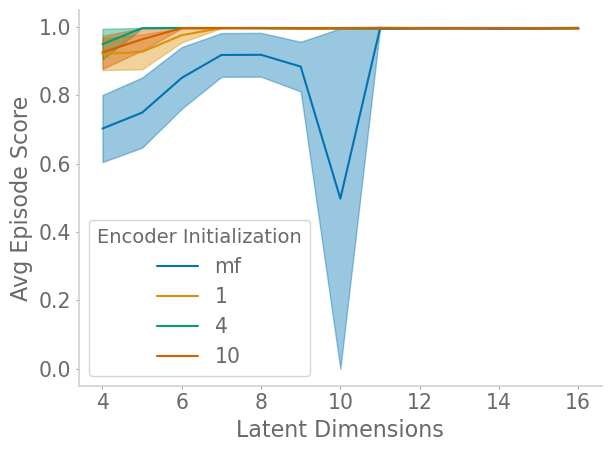

In [37]:
plotA(taskA_df, 'performance', 38, smooth_line=True, smooth_n=3,
      fnames=['mf', '1', '4', '10'],
      smooth_plot=False,
      figname='decodersize_transfer_late', legend_title='Encoder Initialization',
      colors=['C0', 'C1', 'C2', 'C3', 'C4', 'C5']
     )

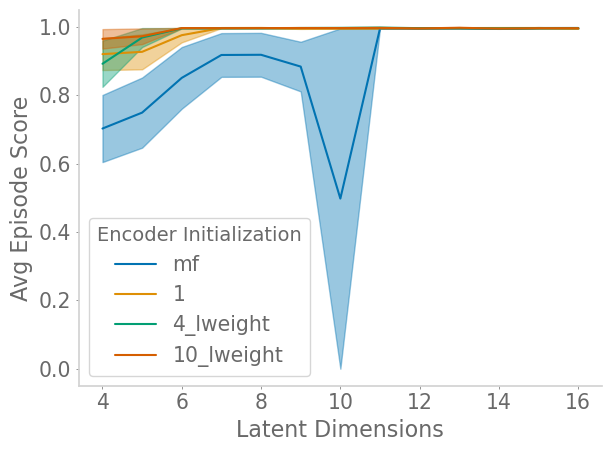

In [38]:
plotA(taskA_df, 'performance', 38, smooth_line=True, smooth_n=3,
      fnames=['mf', '1', '4_lweight', '10_lweight'],
      smooth_plot=False,
      figname='decodersize_transfer_late', legend_title='Encoder Initialization',
      colors=['C0', 'C1', 'C2', 'C3', 'C4', 'C5']
     )

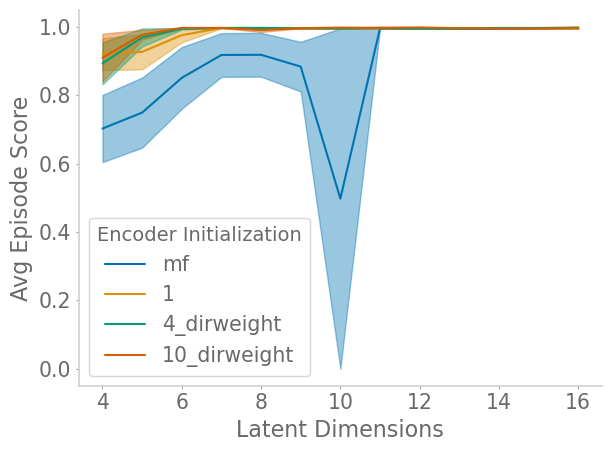

In [45]:
plotA(taskA_df, 'performance', 38, smooth_line=True, smooth_n=3,
      fnames=['mf', '1', '4_dirweight', '10_dirweight'],
      smooth_plot=False,
      figname='decodersize_transfer_late', legend_title='Encoder Initialization',
      colors=['C0', 'C1', 'C2', 'C3', 'C4', 'C5']
     )

# Transfer Results

In [40]:
zs = np.arange(4, 18)

In [41]:
engram_dir = '/mnt/smb/locker/aronov-locker/Ching/rl/'

In [42]:
transfer_data = {
    'performance': [], 'dims': [], 'epochs': [],
    'fname': [], 'z': [], 'steps': []
    }
for z in zs:
    transfer_dir = f'frozentransfer_SRWeightSweep_dm_dim{z}'
    transfer_dir = f'{engram_dir}pickles/{transfer_dir}/'
    if not os.path.exists(transfer_dir):
        continue
    for pickle_file in os.listdir(transfer_dir):
        pickle_file = f'{transfer_dir}{pickle_file}'
        with open(pickle_file, 'rb') as f:
            results = pickle.load(f)
        valid_scores = results['valid_scores']
        valid_steps = results['valid_steps']
        dimensionality_tracking = results['dimensionality_tracking']
        fnames = results['fname']
        n_fname = len(results['fname'])
        n_scores = len(results['valid_scores'])
        multiple = int(n_fname/n_scores)
        for idx in range(n_scores):
            perf = valid_scores[idx]
            steps = valid_steps[idx]
            dim = dimensionality_tracking[idx]
            fname = fnames[idx*multiple]
            fname = fname.split('SRWeightSweep_')[-1]
            for epoch in range(len(perf)):
                transfer_data['performance'].append(perf[epoch])
                transfer_data['steps'].append(steps[epoch])
                transfer_data['dims'].append(dim)
                transfer_data['epochs'].append(epoch)
                transfer_data['fname'].append(fname)
                transfer_data['z'].append(z)
transfer_df = pd.DataFrame(transfer_data)

In [43]:
np.unique(transfer_df['fname'])

array(['1', '10', '10_dirweight', '10_lweight', '2', '2_dirweight',
       '2_lweight', '4', '4_dirweight', '4_lweight', '8', '8_dirweight',
       '8_lweight', 'mf'], dtype=object)

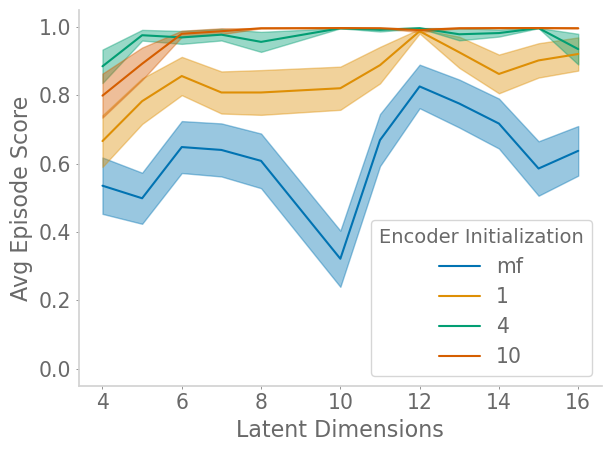

In [49]:
plotA(transfer_df, 'performance', 38, smooth_line=True, smooth_n=3,
      fnames=['mf', '1', '4', '10'],
      smooth_plot=False,
      figname='decodersize_transfer_late', legend_title='Encoder Initialization',
      colors=['C0', 'C1', 'C2', 'C3', 'C4', 'C5']
     )

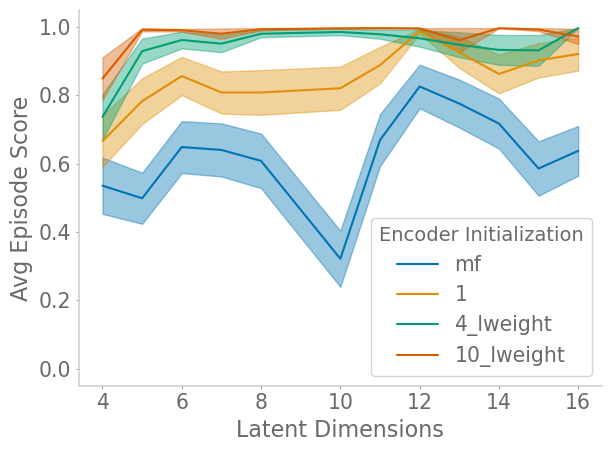

In [50]:
plotA(transfer_df, 'performance', 38, smooth_line=True, smooth_n=3,
      fnames=['mf', '1', '4_lweight', '10_lweight'],
      smooth_plot=False,
      figname='decodersize_transfer_late', legend_title='Encoder Initialization',
      colors=['C0', 'C1', 'C2', 'C3', 'C4', 'C5']
     )

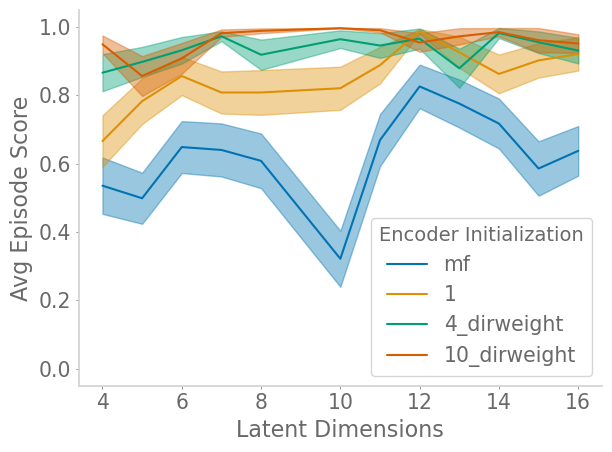

In [51]:
plotA(transfer_df, 'performance', 38, smooth_line=True, smooth_n=3,
      fnames=['mf', '1', '4_dirweight', '10_dirweight'],
      smooth_plot=False,
      figname='decodersize_transfer_late', legend_title='Encoder Initialization',
      colors=['C0', 'C1', 'C2', 'C3', 'C4', 'C5']
     )